In [12]:
import pandas as pd
import os
import re
import numpy as np
import pickle

from collections import Counter

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RepeatedKFold

from sklearn.metrics import f1_score, recall_score, make_scorer
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
sns.set_style('whitegrid')

path = r'C:\Users\chiar\Documents\Università\Text analytics\Data'
#path = r'D:\tirocinioLC\tirocinioLC'

Load Json and select columns

In [2]:
df = pd.read_json(path+'\df_final.json')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37693 entries, 1 to 54718
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype              
---  ------   --------------  -----              
 0   ID       37693 non-null  int64              
 1   Title    37690 non-null  object             
 2   Rating   37693 non-null  object             
 3   Author   37693 non-null  object             
 4   Date     37693 non-null  datetime64[ns, UTC]
 5   Chapter  37693 non-null  int64              
 6   Text     37693 non-null  object             
 7   N_Rev    37693 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(3), object(4)
memory usage: 2.6+ MB
None


,ID,Title,Rating,Author,Date,Chapter,Text,N_Rev
1,2909917,Rilassati! Hai tutta la morte davanti!,verde,Tonks98,2014-11-15 00:00:00+00:00,1,"""Zi zieda, prego. Allora, quale ezzere zuo ""B...",3
4,1390250,Episodi della Old Generation 1.,verde,mrsreg,2012-11-17 00:00:00+00:00,1,Introduzione. Personaggi: Argus Gazza:...,0
5,1143283,In Noctem,verde,LilacLilium,2012-04-07 00:00:00+00:00,1,Questo mio piccolo lavoretto è ispirato a una ...,2
7,917615,Dirty flower.,verde,Rue,2012-07-01 00:00:00+00:00,1,"DIRTY FLOWER. Lo hai sempre saputo, Lily. ...",3
8,917635,Hawthorn and Unicorn Air,giallo,Tonna,2012-08-01 00:00:00+00:00,1,Before you read: Bentro...,4


<AxesSubplot:>

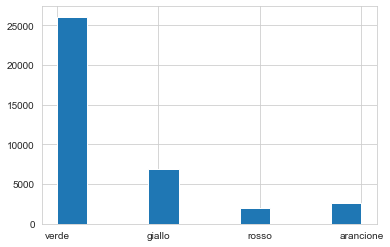

In [3]:
df.Rating.hist()

In [4]:
df.Rating.value_counts()

verde        26104
giallo        6927
arancione     2623
rosso         2039
Name: Rating, dtype: int64

In [5]:
col         = 'Rating'
conditions  = [ (df[col] == 'rosso') | (df[col] == 'arancione'), (df[col] == 'giallo') | (df[col] == 'verde')]
choices     = [ 'rosso', 'verde' ] 
    
df[col] = np.select(conditions, choices, default=np.nan)

df.head()

,ID,Title,Rating,Author,Date,Chapter,Text,N_Rev
1,2909917,Rilassati! Hai tutta la morte davanti!,verde,Tonks98,2014-11-15 00:00:00+00:00,1,"""Zi zieda, prego. Allora, quale ezzere zuo ""B...",3
4,1390250,Episodi della Old Generation 1.,verde,mrsreg,2012-11-17 00:00:00+00:00,1,Introduzione. Personaggi: Argus Gazza:...,0
5,1143283,In Noctem,verde,LilacLilium,2012-04-07 00:00:00+00:00,1,Questo mio piccolo lavoretto è ispirato a una ...,2
7,917615,Dirty flower.,verde,Rue,2012-07-01 00:00:00+00:00,1,"DIRTY FLOWER. Lo hai sempre saputo, Lily. ...",3
8,917635,Hawthorn and Unicorn Air,verde,Tonna,2012-08-01 00:00:00+00:00,1,Before you read: Bentro...,4


<AxesSubplot:>

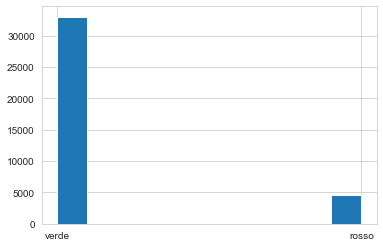

In [6]:
df.Rating.hist()

In [7]:
df.Rating.value_counts()

verde    33031
rosso     4662
Name: Rating, dtype: int64

In [8]:
target = df[['Rating']]
del df['Rating']

In [9]:
from sklearn.model_selection import train_test_split, RepeatedKFold

#split on train-test 
x_train, x_test, y_train, y_test = train_test_split(df, target, test_size=0.30, random_state=42, stratify=target, shuffle=True) 

In [10]:
print(f"Train set size: {len(x_train)}\nTest set size: {len(x_test)}")

Train set size: 26385
Test set size: 11308


In [14]:
print('Train classes distribution%s' % Counter(y_train.Rating))

Train classes distributionCounter({'verde': 23122, 'rosso': 3263})


# Preprocessing

## Feature extraction with nltk and spacy

In [33]:
#!python -m spacy download it_core_news_sm

In [34]:
import nltk
import spacy
import re
nlp = spacy.load('it_core_news_sm')

doc_counter = 0
def reset_counter():
  global doc_counter
  doc_counter = 0

def increase_counter():
  global doc_counter
  doc_counter += 1
  if doc_counter % 100 == 0:
    print(doc_counter)

def spacy_nlp_tokenizer(text):
    increase_counter()

    # substituting all space characters with a single space
    text = re.sub('\s+', ' ', text)

    # we use spacy for main nlp tasks
    doc = nlp(text)
    # lemmatized tokens, skipping stopwords
    lemmas = ['LEMMA_'+token.lemma_ for token in doc if not token.is_stop]
    # entity_types
    entity_types = ['NER_'+token.ent_type_ for token in doc if token.ent_type_]

    # in case an entity linker is available, we can use it do put actual entities as
    # features, e.g. Queen Elizabeth, Elizabeth II, Her Majesty -> KB2912
    # see https://spacy.io/usage/training#entity-linker
    # entities = ['ENT_'+token.ent_kb_id_ for token in doc if token.ent_kb_id_]

    # we use a simple nltk function to create ngrams
    lemma_bigrams = ['BI_'+p1+'_'+p2 for p1,p2 in nltk.ngrams(lemmas,2)]
    lemma_trigrams = ['TRI_'+p1+'_'+p2+'_'+p3 for p1,p2,p3 in nltk.ngrams(lemmas,3)]

    all_tokens = list()
    all_tokens.extend(lemmas)
    all_tokens.extend(lemma_bigrams)
    all_tokens.extend(lemma_trigrams)
    all_tokens.extend(entity_types)
    return all_tokens

In [45]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

### Tokenization 

In [36]:
#vect = CountVectorizer(analyzer=spacy_nlp_tokenizer, min_df=5)  
#reset_counter()
#X_train_tok = vect.fit_transform(x_train.Racconto_Text_Only)
#reset_counter()
#X_test_tok = vect.transform(x_test.Racconto_Text_Only)

In [37]:
#with open(path+r'\Rating\vg_vs_ar\x_train_tok.pkl','wb') as outfile:
#    pickle.dump(X_train_tok,outfile)
#with open(path+r'\Rating\vg_vs_ar\x_test_tok.pkl','wb') as outfile:
#    pickle.dump(X_test_tok,outfile)
#with open(path+r'\Rating\vg_vs_ar\vect.pkl','wb') as outfile:
#    pickle.dump(vect,outfile)

In [38]:
a_file = open(path+r"\Rating\vg_vs_ar\x_train_tok.pkl", "rb")
X_train_tok = pickle.load(a_file)

b_file = open(path+r"\Rating\vg_vs_ar\x_test_tok.pkl", "rb")
X_test_tok = pickle.load(b_file)

c_file = open(path+r"\Rating\vg_vs_ar\vect.pkl", "rb")
vect = pickle.load(c_file)

In [39]:
print(f"Lunghezza del vocabolario: {len(vect.vocabulary_)}")

Lunghezza del vocabolario: 911443


In [40]:
#vect.vocabulary_

In [41]:
#vect.inverse_transform(X_train_tok[0,:])

# Rating Classification

In [42]:
rating_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k=5000)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm 
])

#class_weight = {'rosso':10, 'verde': 5} - inversamente proporzionale: try 9:1
#oversampling 
#normalizzare lunghezza documenti
#(nel caso) tentare verde/giallo/rosso&arancione

reset_counter()
rating_pipeline.fit(X_train_tok, y_train)

reset_counter()
rating_predictions = rating_pipeline.predict(X_test_tok)

rating_correct = 0
rating_true_labels = [x[0] for x in y_test.values]

for prediction,true_label in zip(rating_predictions, rating_true_labels):
    if prediction==true_label:
        rating_correct += 1
        
print(f"Accuracy: {(rating_correct/len(rating_predictions)):.2f}")

C:\Users\chiar\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy: 0.91


In [43]:
from sklearn.metrics import confusion_matrix, classification_report
print('Classification report:')
print(classification_report(y_test, rating_predictions))
print('Confusion matrix:')
rating_cm = confusion_matrix(y_test, rating_predictions)
print(rating_cm)

Classification report:
              precision    recall  f1-score   support

       rosso       0.85      0.37      0.52      1399
       verde       0.92      0.99      0.95      9909

    accuracy                           0.91     11308
   macro avg       0.89      0.68      0.74     11308
weighted avg       0.91      0.91      0.90     11308

Confusion matrix:
[[ 524  875]
 [  90 9819]]


## Optimization 

In [36]:
search_space = [{'sel__k': [10000, 100000, 250000, 500000, 'all'],
                 'learner':[MultinomialNB()],
                 'learner__alpha': [1e-3, 1e-2, 0.1, 1.0, 10.0],
                 'learner__fit_prior':[True, False]}, 
                {'sel__k': [10000, 100000, 250000, 500000, 'all'],
                 'learner':[LinearSVC()],
                 'learner__C': [0.01, 0.1, 1, 10, 100]},
                {'sel__k': [10000, 100000, 250000, 500000, 'all'], 
                 'learner':[LogisticRegression()],
                 'learner__solver':["liblinear"],
                 'learner__penalty' : ['l1', 'l2'],
                 'learner__C': [0.01, 0.1, 1, 10, 100]} 
               ]

rating_opt_pipeline = Pipeline([
#    ('vect', CountVectorizer()),  # feature extraction
    ('sel', SelectKBest(chi2)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

scoring = make_scorer(f1_score, greater_is_better=True, pos_label='rosso')

In [ ]:
rating_opt_search = GridSearchCV(rating_opt_pipeline,
                                 search_space,
                                 scoring = scoring,
                                 cv=3, n_jobs = -1, 
                                 verbose=True).fit(X_train_tok,y_train) 

In [33]:
rating_opt_search.best_params_

{'learner': LogisticRegression(C=10, penalty='l1', solver='liblinear'),
 'learner__C': 10,
 'learner__penalty': 'l1',
 'learner__solver': 'liblinear',
 'sel__k': 'all'}

In [34]:
rating_opt_search.cv_results_

{'mean_fit_time': array([  5.50078424,   7.13442206,   9.74158486,  14.60891136,
         21.39884297,   7.77886438,   8.02120248,  10.21145105,
         14.95896475,  19.28075711,   6.99922546,   7.00643174,
          9.94244035,  13.56615973,  19.33290728,   6.47033676,
          7.68188079,   9.53716262,  13.04458769,  18.86332631,
          6.51566188,   7.26254018,   9.61450545,  13.08881052,
         19.20187902,   6.43723194,   7.54131325,   9.16397786,
         13.64159282,  18.44697674,   6.56073356,   7.04083737,
          9.486039  ,  13.17730832,  18.94711987,   6.49846005,
          7.19908611,   9.04209916,  13.41846999,  18.56237857,
          6.41919653,   7.21794271,   9.53336088,  13.57595309,
         19.09750017,   6.71879959,   7.82156452,   9.17661468,
         13.50198523,  17.81698219,   7.03633308,   8.34577958,
         10.84301146,  17.89437906,  26.06436062,   8.37206181,
         10.12753709,  12.52579705,  20.16267093,  27.86237899,
         11.05699468,  

In [35]:
rating_opt_search.best_estimator_

Pipeline(steps=[('sel',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x00000115020D2C10>)),
                ('tfidf', TfidfTransformer()),
                ('learner',
                 LogisticRegression(C=10, penalty='l1', solver='liblinear'))])

In [36]:
rating_opt_predictions = rating_opt_search.best_estimator_.predict(X_test_tok)

rating_correct = 0
rating_true_labels = [x for x in y_test.Rating]

for prediction,rating_true_labels in zip(rating_opt_predictions, rating_true_labels):
    if prediction==rating_true_labels:
        rating_correct += 1
        
print(f"Accuracy: {(rating_correct/len(rating_opt_predictions)):.2f}")

Accuracy: 0.91


In [37]:
rating_opt_predictions = rating_opt_search.best_estimator_.predict(X_test_tok)

print('Classification report:')
print(classification_report(y_test, rating_opt_predictions))
print('Confusion matrix:')
rating_opt_cm = confusion_matrix(y_test, rating_opt_predictions)
print(rating_opt_cm)

Classification report:
              precision    recall  f1-score   support

       rosso       0.74      0.48      0.58      1399
       verde       0.93      0.98      0.95      9909

    accuracy                           0.91     11308
   macro avg       0.83      0.73      0.77     11308
weighted avg       0.91      0.91      0.91     11308

Confusion matrix:
[[ 673  726]
 [ 242 9667]]


#  Class weight optimization

## Class Weight: 9 vs 1 (GridSearchCV) 

In [40]:
search_space = [{'sel__k': [10000, 100000, 250000, 500000, 'all'],
                 'learner':[MultinomialNB(class_prior = [.9, .1])],
                 'learner__alpha': [1e-3, 1e-2, 0.1, 1.0, 10.0],
                 'learner__fit_prior':[True, False]}, 
                {'sel__k': [10000, 100000, 250000, 500000, 'all'],
                 'learner':[LinearSVC(class_weight = {'rosso':9, 'verde': 1})],
                 'learner__C': [0.01, 0.1, 1, 10, 100]},
                {'sel__k': [10000, 100000, 250000, 500000, 'all'], 
                 'learner':[LogisticRegression(class_weight = {'rosso':9, 'verde': 1})],
                 'learner__solver':["liblinear"],
                 'learner__penalty' : ['l1', 'l2'],
                 'learner__C': [0.01, 0.1, 1, 10, 100]} 
               ]

rating_opt2_pipeline = Pipeline([
#    ('vect', CountVectorizer()),  # feature extraction
    ('sel', SelectKBest(chi2)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

In [41]:
rating_opt2_search = GridSearchCV(rating_opt2_pipeline,
                                 search_space,
                                 scoring = scoring,
                                 cv=3, n_jobs = -1, 
                                 verbose=True).fit(X_train_tok,y_train) 

Fitting 3 folds for each of 125 candidates, totalling 375 fits


C:\Users\chiar\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [42]:
rating_opt2_search.best_params_

{'learner': LogisticRegression(C=10, class_weight={'rosso': 9, 'verde': 1},
                    solver='liblinear'),
 'learner__C': 10,
 'learner__penalty': 'l2',
 'learner__solver': 'liblinear',
 'sel__k': 'all'}

In [43]:
rating_opt2_search.cv_results_

{'mean_fit_time': array([   7.4890031 ,   10.23055927,   10.97140169,   22.11648122,
          23.78249367,    8.44788639,   10.02125065,   12.02084756,
          15.73239573,   21.71476022,    7.65875912,    9.46140957,
          12.48510973,   18.11242604,   23.69939001,    7.85046593,
           9.62912885,   11.84212963,   16.4920578 ,   22.52606146,
           7.59258747,    8.97834516,   10.96797601,   16.30722491,
          23.86457348,    8.55665445,    9.8241744 ,   12.76043574,
          17.75778874,   24.40364806,    8.24980974,    9.96568418,
          13.37281982,   17.84074537,   23.74234549,    8.6766901 ,
          10.14422774,   13.60740868,   19.59906189,   26.94123618,
           9.2740949 ,   10.98379016,   14.47179111,   18.57835086,
          24.13475982,    7.55631097,    8.72146201,   11.59154193,
          17.76958847,   22.31434576,    9.24703622,   11.57881562,
          15.21128352,   23.01671155,   32.66660873,   12.96241967,
          16.12140703,   23.897

In [44]:
rating_opt2_search.best_estimator_

Pipeline(steps=[('sel',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x000001FD63305C10>)),
                ('tfidf', TfidfTransformer()),
                ('learner',
                 LogisticRegression(C=10, class_weight={'rosso': 9, 'verde': 1},
                                    solver='liblinear'))])

In [45]:
rating_opt2_predictions = rating_opt2_search.best_estimator_.predict(X_test_tok)

rating_correct = 0
rating_true_labels = [x for x in y_test.Rating]

for prediction,rating_true_labels in zip(rating_opt2_predictions, rating_true_labels):
    if prediction==rating_true_labels:
        rating_correct += 1
        
print(f"Accuracy: {(rating_correct/len(rating_opt2_predictions)):.2f}")

Accuracy: 0.91


In [46]:
rating_opt2_predictions = rating_opt2_search.best_estimator_.predict(X_test_tok)

print('Classification report:')
print(classification_report(y_test, rating_opt2_predictions))
print('Confusion matrix:')
rating_opt2_cm = confusion_matrix(y_test, rating_opt2_predictions)
print(rating_opt2_cm)

Classification report:
              precision    recall  f1-score   support

       rosso       0.67      0.58      0.62      1399
       verde       0.94      0.96      0.95      9909

    accuracy                           0.91     11308
   macro avg       0.81      0.77      0.79     11308
weighted avg       0.91      0.91      0.91     11308

Confusion matrix:
[[ 816  583]
 [ 397 9512]]


## Class Weight 20 vs 1

In [48]:
rating_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k='all')),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LogisticRegression(C=10, class_weight={'rosso': 20, 'verde': 1},
                    solver='liblinear', penalty='l2'))  # learning algorithm 
])

reset_counter()
rating_pipeline.fit(X_train_tok, y_train.values.ravel())

reset_counter()
rating_predictions = rating_pipeline.predict(X_test_tok)

In [49]:
print('Classification report:')
print(classification_report(y_test, rating_predictions))
print('Confusion matrix:')
rating_cm = confusion_matrix(y_test, rating_predictions)
print(rating_cm)

Classification report:
              precision    recall  f1-score   support

       rosso       0.60      0.64      0.62      1399
       verde       0.95      0.94      0.94      9909

    accuracy                           0.90     11308
   macro avg       0.78      0.79      0.78     11308
weighted avg       0.91      0.90      0.90     11308

Confusion matrix:
[[ 889  510]
 [ 584 9325]]


### Class weight: 20 vs 1 (GridSearchCV) 

In [50]:
search_space_opt3 = [{'sel__k': [10000, 100000, 250000, 500000, 'all'],
                 'learner':[MultinomialNB(class_prior = [2, .1])],
                 'learner__alpha': [1e-3, 1e-2, 0.1, 1.0, 10.0],
                 'learner__fit_prior':[True, False]}, 
                {'sel__k': [10000, 100000, 250000, 500000, 'all'],
                 'learner':[LinearSVC(class_weight = {'rosso':20, 'verde': 1})],
                 'learner__C': [0.01, 0.1, 1, 10, 100]},
                {'sel__k': [10000, 100000, 250000, 500000, 'all'], 
                 'learner':[LogisticRegression(class_weight = {'rosso':20, 'verde': 1})],
                 'learner__solver':["liblinear"],
                 'learner__penalty' : ['l1', 'l2'],
                 'learner__C': [0.01, 0.1, 1, 10, 100]} 
               ]

rating_opt3_pipeline = Pipeline([
#    ('vect', CountVectorizer()),  # feature extraction
    ('sel', SelectKBest(chi2)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

In [54]:
rating_opt3_search = GridSearchCV(rating_opt3_pipeline,
                                 search_space_opt3,
                                 scoring = scoring,
                                 cv=3, n_jobs = -1, 
                                 verbose=True).fit(X_train_tok, y_train.values.ravel())

Fitting 3 folds for each of 125 candidates, totalling 375 fits


In [55]:
rating_opt3_search.best_params_

{'learner': LogisticRegression(C=10, class_weight={'rosso': 20, 'verde': 1},
                    solver='liblinear'),
 'learner__C': 10,
 'learner__penalty': 'l2',
 'learner__solver': 'liblinear',
 'sel__k': 'all'}

In [56]:
rating_opt3_search.cv_results_

{'mean_fit_time': array([  8.28823837,   9.92818077,  12.4100124 ,  14.81506308,
         21.77827454,   7.65412958,   9.04591608,  11.71597743,
         15.48722521,  21.65498837,   7.74997822,   8.53446062,
         10.04583891,  13.9845655 ,  19.13450742,   6.68369635,
          7.74186738,   9.37940494,  14.6637373 ,  19.3148466 ,
          6.8929139 ,   7.87058489,  10.28275323,  15.25372521,
         19.76160431,   6.9887073 ,   8.07735531,  10.06284738,
         14.10179853,  19.80658531,   7.42584435,   8.19888663,
         10.04642924,  14.43125431,  20.38102055,   7.03331391,
          8.7826399 ,  10.5404315 ,  15.51276771,  19.44028616,
          7.56138349,   8.16912166,   9.90912636,  15.61493278,
         20.02671758,   7.46695566,   8.04331128,  10.93386118,
         14.65846014,  20.0833687 ,   8.56924359,  10.7881341 ,
         13.40834816,  22.00562557,  30.67778532,  14.85048501,
         17.14095283,  30.30790226,  52.72257535,  67.57609614,
         48.57072639,  

In [57]:
rating_opt3_search.best_estimator_

Pipeline(steps=[('sel',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x00000209DFB01700>)),
                ('tfidf', TfidfTransformer()),
                ('learner',
                 LogisticRegression(C=10,
                                    class_weight={'rosso': 20, 'verde': 1},
                                    solver='liblinear'))])

In [58]:
rating_opt3_predictions = rating_opt3_search.best_estimator_.predict(X_test_tok)

rating_correct = 0
rating_true_labels = [x for x in y_test.Rating]

for prediction,rating_true_labels in zip(rating_opt3_predictions, rating_true_labels):
    if prediction==rating_true_labels:
        rating_correct += 1
        
print(f"Accuracy: {(rating_correct/len(rating_opt3_predictions)):.2f}")

Accuracy: 0.90


In [59]:
rating_opt3_predictions = rating_opt3_search.best_estimator_.predict(X_test_tok)

print('Classification report:')
print(classification_report(y_test, rating_opt3_predictions))
print('Confusion matrix:')
rating_opt3_cm = confusion_matrix(y_test, rating_opt3_predictions)
print(rating_opt3_cm)

Classification report:
              precision    recall  f1-score   support

       rosso       0.60      0.64      0.62      1399
       verde       0.95      0.94      0.94      9909

    accuracy                           0.90     11308
   macro avg       0.78      0.79      0.78     11308
weighted avg       0.91      0.90      0.90     11308

Confusion matrix:
[[ 889  510]
 [ 584 9325]]


# Undersampling

In [19]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [39]:
# define undersample strategy
rus = RandomUnderSampler(random_state=42)

In [40]:
X_und, y_und = rus.fit_resample(x_train, y_train)
print('Resampled dataset shape %s' % Counter(y_und.Rating))

Resampled dataset shape Counter({'rosso': 3263, 'verde': 3263})


In [41]:
#vect_und = CountVectorizer(analyzer=spacy_nlp_tokenizer, min_df=5)  
#reset_counter()
#X_train_und_tok = vect_und.fit_transform(X_und.Racconto_Text_Only)
#reset_counter()
#X_test_und_tok = vect_und.transform(x_test.Racconto_Text_Only)

In [42]:
#with open(path+r'\Rating\vg_vs_ar\X_train_und_tok.pkl','wb') as outfile:
#    pickle.dump(X_train_und_tok,outfile)
#with open(path+r'\Rating\vg_vs_ar\X_test_und_tok.pkl','wb') as outfile:
#    pickle.dump(X_test_und_tok,outfile)
#with open(path+r'\Rating\vg_vs_ar\vect_und.pkl','wb') as outfile:
#    pickle.dump(vect_und,outfile)

In [43]:
a_file = open(path+r"\Rating\vg_vs_ar\X_train_und_tok.pkl", "rb")
X_train_und_tok = pickle.load(a_file)

b_file = open(path+r"\Rating\vg_vs_ar\X_test_und_tok.pkl", "rb")
X_test_und_tok = pickle.load(b_file)

c_file = open(path+r"\Rating\vg_vs_ar\vect_und.pkl", "rb")
vect_und = pickle.load(c_file)

In [44]:
rating_und_opt_pipeline = Pipeline([
#    ('vect', CountVectorizer()),  # feature extraction
    ('sel', SelectKBest(chi2)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

In [45]:
rating_und_opt_search = GridSearchCV(rating_und_opt_pipeline, 
                                     search_space, 
                                     scoring = scoring, 
                                     cv=3, n_jobs = -1, verbose=True).fit(X_train_und_tok, y_und)

Fitting 3 folds for each of 125 candidates, totalling 375 fits


C:\Users\chiar\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.73719922 0.73970641 0.74425827        nan 0.7479372  0.7374046
 0.73986448 0.74441678        nan 0.74819475 0.73011605 0.76484907
 0.75966977        nan 0.75712325 0.73053693 0.7650301  0.75984999
        nan 0.75730241 0.7074544  0.67542112 0.74790043        nan
 0.75499765 0.7076803  0.67567193 0.74809878        nan 0.75518292
 0.61604968 0.7384712  0.72575172        nan 0.71024506 0.61604972
 0.73867393 0.72581793        nan 0.71039213 0.69556986 0.72003883
 0.67932626        nan 0.6737319  0.69567245 0.7201069  0.67946499
        nan 0.67393949 0.69754743 0.70220842 0.68815396        nan
 0.68393202 0.73408534 0.73549812 0.73453757        nan 0.73128078
 0.75759232 0.77056755 0.76949118        nan 0.76669137 0.74086522
 0.76355639 0.77060082        nan 0.76988538 0.72308339 0.74563529
 0.75867819        nan 0.76094836 0.

In [46]:
rating_und_opt_search.best_params_

{'learner': LogisticRegression(C=100, solver='liblinear'),
 'learner__C': 100,
 'learner__penalty': 'l2',
 'learner__solver': 'liblinear',
 'sel__k': 'all'}

In [47]:
rating_und_opt_search.best_estimator_

Pipeline(steps=[('sel',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x00000115020D2C10>)),
                ('tfidf', TfidfTransformer()),
                ('learner', LogisticRegression(C=100, solver='liblinear'))])

In [48]:
rating_und_opt_predictions = rating_und_opt_search.best_estimator_.predict(X_test_und_tok)

rating_und_correct = 0
rating_und_true_labels = [x for x in y_test.Rating]

for prediction,rating_und_true_labels in zip(rating_und_opt_predictions, rating_und_true_labels):
    if prediction==rating_und_true_labels:
        rating_und_correct += 1
        
print(f"Accuracy: {(rating_und_correct/len(rating_und_opt_predictions)):.2f}")

Accuracy: 0.81


In [49]:
rating_und_opt_predictions = rating_und_opt_search.best_estimator_.predict(X_test_und_tok)

print('Classification report:')
print(classification_report(y_test, rating_und_opt_predictions))
print('Confusion matrix:')
rating_und_opt_cm = confusion_matrix(y_test, rating_und_opt_predictions)
print(rating_und_opt_cm)

Classification report:
              precision    recall  f1-score   support

       rosso       0.38      0.79      0.51      1399
       verde       0.96      0.82      0.88      9909

    accuracy                           0.81     11308
   macro avg       0.67      0.80      0.70     11308
weighted avg       0.89      0.81      0.84     11308

Confusion matrix:
[[1100  299]
 [1811 8098]]


## 0.5 

In [50]:
# define undersample strategy
rus = RandomUnderSampler(sampling_strategy=0.5, random_state=42)

In [51]:
X_und2, y_und2 = rus.fit_resample(x_train, y_train)
print('Resampled dataset shape %s' % Counter(y_und2.Rating))

Resampled dataset shape Counter({'verde': 6526, 'rosso': 3263})


In [52]:
#vect_und2 = CountVectorizer(analyzer=spacy_nlp_tokenizer, min_df=5)  
#reset_counter()
#X_train_und2_tok = vect_und2.fit_transform(X_und2.Racconto_Text_Only)
#reset_counter()
#X_test_und2_tok = vect_und2.transform(x_test.Racconto_Text_Only)

In [53]:
#with open(path+r'\Rating\vg_vs_ar\X_train_und2_tok.pkl','wb') as outfile:
#    pickle.dump(X_train_und2_tok,outfile)
#with open(path+r'\Rating\vg_vs_ar\X_test_und2_tok.pkl','wb') as outfile:
#    pickle.dump(X_test_und2_tok,outfile)
#with open(path+r'\Rating\vg_vs_ar\vect_und2.pkl','wb') as outfile:
#    pickle.dump(vect_und2,outfile)

In [54]:
a_file = open(path+r"\Rating\vg_vs_ar\X_train_und2_tok.pkl", "rb")
X_train_und2_tok = pickle.load(a_file)

b_file = open(path+r"\Rating\vg_vs_ar\X_test_und2_tok.pkl", "rb")
X_test_und2_tok = pickle.load(b_file)

c_file = open(path+r"\Rating\vg_vs_ar\vect_und2.pkl", "rb")
vect_und2 = pickle.load(c_file)

In [55]:
rating_und2_opt_pipeline = Pipeline([
#    ('vect', CountVectorizer()),  # feature extraction
    ('sel', SelectKBest(chi2)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

In [56]:
rating_und2_opt_search = GridSearchCV(rating_und2_opt_pipeline, 
                                      search_space, 
                                      scoring = scoring,
                                      cv=3, n_jobs = -1, verbose=True).fit(X_train_und2_tok, y_und2)

Fitting 3 folds for each of 125 candidates, totalling 375 fits


C:\Users\chiar\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.62991001 0.67280647 0.6813167         nan 0.67273671 0.66804217
 0.63893896 0.67785526        nan 0.67816164 0.62111407 0.67417732
 0.67141059        nan 0.67458178 0.66497957 0.6775054  0.68295107
        nan 0.68107485 0.58143519 0.49997397 0.51171974        nan
 0.54286911 0.65554378 0.57371176 0.58232423        nan 0.60904235
 0.38130878 0.03492763 0.01519188        nan 0.0206171  0.50726627
 0.07932861 0.05300016        nan 0.06454284 0.         0.
 0.                nan 0.         0.01940001 0.00183599 0.00183599
        nan 0.00183599 0.2441382  0.19026931 0.22401476        nan
 0.2926281  0.57860634 0.57439829 0.57800234        nan 0.58591277
 0.66300236 0.6697769  0.66949761        nan 0.66754198 0.65419257
 0.67371673 0.68423335        nan 0.68513297 0.6230803  0.65660684
 0.67263942        nan 0.67842189 0.       

In [57]:
rating_und2_opt_search.best_params_

{'learner': LinearSVC(C=10), 'learner__C': 10, 'sel__k': 'all'}

In [58]:
rating_und2_opt_search.best_estimator_

Pipeline(steps=[('sel',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x00000115020D2C10>)),
                ('tfidf', TfidfTransformer()), ('learner', LinearSVC(C=10))])

In [59]:
rating_und2_opt_predictions = rating_und2_opt_search.best_estimator_.predict(X_test_und2_tok)

rating_und2_correct = 0
rating_und2_true_labels = [x for x in y_test.Rating]

for prediction,rating_und2_true_labels in zip(rating_und2_opt_predictions, rating_und2_true_labels):
    if prediction==rating_und2_true_labels:
        rating_und2_correct += 1
        
print(f"Accuracy: {(rating_und2_correct/len(rating_und2_opt_predictions)):.2f}")

Accuracy: 0.89


In [60]:
rating_und2_opt_predictions = rating_und2_opt_search.best_estimator_.predict(X_test_und2_tok)

print('Classification report:')
print(classification_report(y_test, rating_und2_opt_predictions))
print('Confusion matrix:')
rating_und2_opt_cm = confusion_matrix(y_test, rating_und2_opt_predictions)
print(rating_und2_opt_cm)

Classification report:
              precision    recall  f1-score   support

       rosso       0.55      0.65      0.60      1399
       verde       0.95      0.92      0.94      9909

    accuracy                           0.89     11308
   macro avg       0.75      0.79      0.77     11308
weighted avg       0.90      0.89      0.89     11308

Confusion matrix:
[[ 914  485]
 [ 759 9150]]


# Oversampling 

In [20]:
# define undersample strategy
ros = RandomOverSampler(random_state=42)

In [21]:
X_over, y_over = ros.fit_resample(x_train, y_train)
print('Resampled dataset shape %s' % Counter(y_over.Rating))

Resampled dataset shape Counter({'verde': 23122, 'rosso': 23122})


In [36]:
#vect_over = CountVectorizer(analyzer=spacy_nlp_tokenizer, min_df=5)  
#reset_counter()
#X_train_over_tok = vect_over.fit_transform(X_over.Racconto_Text_Only)
#reset_counter()
#X_test_over_tok = vect_over.transform(x_test.Racconto_Text_Only)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300


In [38]:
#with open(path+r'\Rating\vg_vs_ar\X_train_over_tok.pkl','wb') as outfile:
#    pickle.dump(X_train_over_tok,outfile)
#with open(path+r'\Rating\vg_vs_ar\X_test_over_tok.pkl','wb') as outfile:
#    pickle.dump(X_test_over_tok,outfile)
#with open(path+r'\Rating\vg_vs_ar\vect_over.pkl','wb') as outfile:
#    pickle.dump(vect_over,outfile)

In [39]:
a_file = open(path+r"\Rating\vg_vs_ar\X_train_over_tok.pkl", "rb")
X_train_over_tok = pickle.load(a_file)

b_file = open(path+r"\Rating\vg_vs_ar\X_test_over_tok.pkl", "rb")
X_test_over_tok = pickle.load(b_file)

c_file = open(path+r"\Rating\vg_vs_ar\vect_over.pkl", "rb")
vect_over = pickle.load(c_file)

In [53]:
search_space = [{'sel__k': [10000, 100000, 250000, 500000, 'all'],
                 'learner':[MultinomialNB()],
                 'learner__alpha': [1e-3, 1e-2, 0.1, 1.0, 10.0],
                 'learner__fit_prior':[True, False]}, 
                {'sel__k': [10000, 100000, 250000, 500000, 'all'],
                 'learner':[LinearSVC()],
                 'learner__C': [0.01, 0.1, 1, 10, 100]},
                {'sel__k': [10000, 100000, 250000, 500000, 'all'], 
                 'learner':[LogisticRegression()],
                 'learner__solver':["liblinear"],
                 'learner__penalty' : ['l1', 'l2'],
                 'learner__C': [0.01, 0.1, 1, 10, 100]} 
               ]

rating_over_opt_pipeline = Pipeline([
#    ('vect', CountVectorizer()),  # feature extraction
    ('sel', SelectKBest(chi2)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

scoring = make_scorer(f1_score, greater_is_better=True, pos_label='rosso')

In [41]:
rating_over_opt_search = GridSearchCV(rating_over_opt_pipeline, 
                                     search_space, 
                                     scoring = scoring, 
                                     cv=3, n_jobs = -1, verbose=True).fit(X_train_over_tok, y_over)

Fitting 3 folds for each of 125 candidates, totalling 375 fits


C:\Users\chiar\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [42]:
rating_over_opt_search.best_params_

{'learner': LinearSVC(C=10), 'learner__C': 10, 'sel__k': 'all'}

In [43]:
rating_over_opt_search.best_estimator_

Pipeline(steps=[('sel',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x000001516A1E5DC0>)),
                ('tfidf', TfidfTransformer()), ('learner', LinearSVC(C=10))])

In [44]:
rating_over_opt_predictions = rating_over_opt_search.best_estimator_.predict(X_test_over_tok)

rating_over_correct = 0
rating_over_true_labels = [x for x in y_test.Rating]

for prediction,rating_over_true_labels in zip(rating_over_opt_predictions, rating_over_true_labels):
    if prediction==rating_over_true_labels:
        rating_over_correct += 1
        
print(f"Accuracy: {(rating_over_correct/len(rating_over_opt_predictions)):.2f}")

Accuracy: 0.91


In [45]:
from sklearn.metrics import confusion_matrix, classification_report
rating_over_opt_predictions = rating_over_opt_search.best_estimator_.predict(X_test_over_tok)

print('Classification report:')
print(classification_report(y_test, rating_over_opt_predictions))
print('Confusion matrix:')
rating_over_opt_cm = confusion_matrix(y_test, rating_over_opt_predictions)
print(rating_over_opt_cm)

Classification report:
              precision    recall  f1-score   support

       rosso       0.84      0.38      0.52      1399
       verde       0.92      0.99      0.95      9909

    accuracy                           0.91     11308
   macro avg       0.88      0.68      0.74     11308
weighted avg       0.91      0.91      0.90     11308

Confusion matrix:
[[ 532  867]
 [ 103 9806]]


## Best model: Class weight 20:1 - Inspecting the Pipeline

In [60]:
model_opt_pipeline = Pipeline(steps=[('sel',
                 SelectKBest(k='all',
                             score_func=chi2)),
                ('tfidf', TfidfTransformer()),
                ('learner',
                 LogisticRegression(C=10,
                                    class_weight={'rosso': 20, 'verde': 1},
                                    solver='liblinear'))])

In [61]:
model_opt_pipeline.fit(X_train_tok, y_train.values.ravel())

Pipeline(steps=[('sel',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x00000209DFB01700>)),
                ('tfidf', TfidfTransformer()),
                ('learner',
                 LogisticRegression(C=10,
                                    class_weight={'rosso': 20, 'verde': 1},
                                    solver='liblinear'))])

In [62]:
rating_tokenizer = vect
rating_selector = model_opt_pipeline.named_steps['sel']
rating_classifier = model_opt_pipeline.named_steps['learner']

In [63]:
rating_feature_names = rating_tokenizer.get_feature_names()
rating_feats_w_score = list()
for index,(selected,score) in enumerate(zip(rating_selector.get_support(),rating_selector.scores_)):
    rating_feats_w_score.append((score,selected,rating_feature_names[index]))
rating_feats_w_score = sorted(rating_feats_w_score)
len(rating_feats_w_score)

911443

In [64]:
#rating_feats_w_score[:100],rating_feats_w_score[-100:]

In [65]:
rating_feats_w_classifier_weight = list()
for index,weight in enumerate(rating_selector.inverse_transform(rating_classifier.coef_)[0]):
    if weight!=0:
        rating_feats_w_classifier_weight.append((weight,rating_feature_names[index]))
rating_feats_w_classifier_weight = sorted(rating_feats_w_classifier_weight)
len(rating_feats_w_classifier_weight)

911443

In [66]:
rating_feats_w_classifier_weight[-100:]

[(3.0315734108499393, 'LEMMA_lacrima'),
 (3.036774913161319, 'LEMMA_silenziare'),
 (3.0382158354857047, 'LEMMA_muro'),
 (3.0462282007379677, 'LEMMA_torto'),
 (3.0517666303823026, 'LEMMA_Sai'),
 (3.063252435764093, 'BI_LEMMA_;_LEMMA_e'),
 (3.065011157555644, 'BI_LEMMA_morire_LEMMA_,'),
 (3.0716020009998113, 'BI_LEMMA_lo_LEMMA_scrivere'),
 (3.0738947705041593, 'LEMMA_amicizia'),
 (3.080184946738424, 'BI_LEMMA_volere_LEMMA_andare'),
 (3.0935815349234197, 'LEMMA_saltellare'),
 (3.0976090631110393, 'BI_LEMMA_venire_LEMMA_mentire'),
 (3.099010378552887, 'LEMMA_idiota'),
 (3.1011021379107206, 'LEMMA_adorare'),
 (3.107717124937904, 'LEMMA_Grattastinchi'),
 (3.11633585333988, 'LEMMA_increspare'),
 (3.119578844351076, 'LEMMA_rassegnare'),
 (3.125103668290136, 'BI_LEMMA_scrivere_LEMMA_,'),
 (3.130878786463479, 'TRI_LEMMA_-_LEMMA_._LEMMA_-'),
 (3.138975257794404, 'LEMMA_gigante'),
 (3.1479215979162114, 'LEMMA_vestire'),
 (3.149091645195105, 'BI_LEMMA_“_LEMMA_...'),
 (3.1543930785923795, 'LEMMA_cod

In [67]:
rating_feats_w_classifier_weight[:100]

[(-18.097778635466, 'LEMMA_corpo'),
 (-16.810622086790264, 'LEMMA_gemito'),
 (-15.63512568075024, 'LEMMA_sesso'),
 (-15.451257567287875, 'LEMMA_seno'),
 (-12.59878864153141, 'LEMMA_lingua'),
 (-11.821674736945305, 'LEMMA_orgasmo'),
 (-11.627788691586755, 'LEMMA_erezione'),
 (-10.5952269042034, 'LEMMA_pantalone'),
 (-10.516864989902631, 'LEMMA_gamba'),
 (-10.311711403436751, 'LEMMA_collare'),
 (-10.210643204059814, 'LEMMA_spingere'),
 (-10.107646599273288, 'LEMMA_gemere'),
 (-10.10698577135987, 'LEMMA_capitolare'),
 (-10.023642462329745, 'LEMMA_spinto'),
 (-9.88785642102203, 'LEMMA_bocca'),
 (-9.64356367340396, 'LEMMA_nudo'),
 (-9.282737711496287, 'LEMMA_coscia'),
 (-9.251168581281776, 'LEMMA_scendere'),
 (-8.83613388813969, 'LEMMA_eccitare'),
 (-8.585669212319274, 'LEMMA_passione'),
 (-8.38834621977512, 'LEMMA_labbro'),
 (-8.11121583680865, 'LEMMA_pelle'),
 (-8.063459075700171, 'LEMMA_dito'),
 (-8.02438806124627, 'LEMMA_prologo'),
 (-7.848542989677528, 'LEMMA_eccitazione'),
 (-7.690778